# Vendor Performance Analysis

Statistical analysis of vendor performance metrics to identify optimization opportunities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
from scipy.stats import ttest_ind
from pathlib import Path
import sys
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Load Data

In [2]:
try:
    sys.path.insert(0, str(Path.cwd().parent / 'config'))
    from config_loader import get_config, get_project_root
    config = get_config()
    DB_PATH = get_project_root() / config.database_path
    print('✅ Config loaded:')
except ImportError:
    DB_PATH = 'inventory.db'
    print('⚠️ Using default DB path')

conn = sqlite3.connect(str(DB_PATH))
df = pd.read_sql_query('SELECT * FROM vendor_sales_summary', conn)
print(f'Loaded {len(df):,} rows')

✅ Config loaded:
Loaded 10,692 rows


## Exploratory Analysis

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


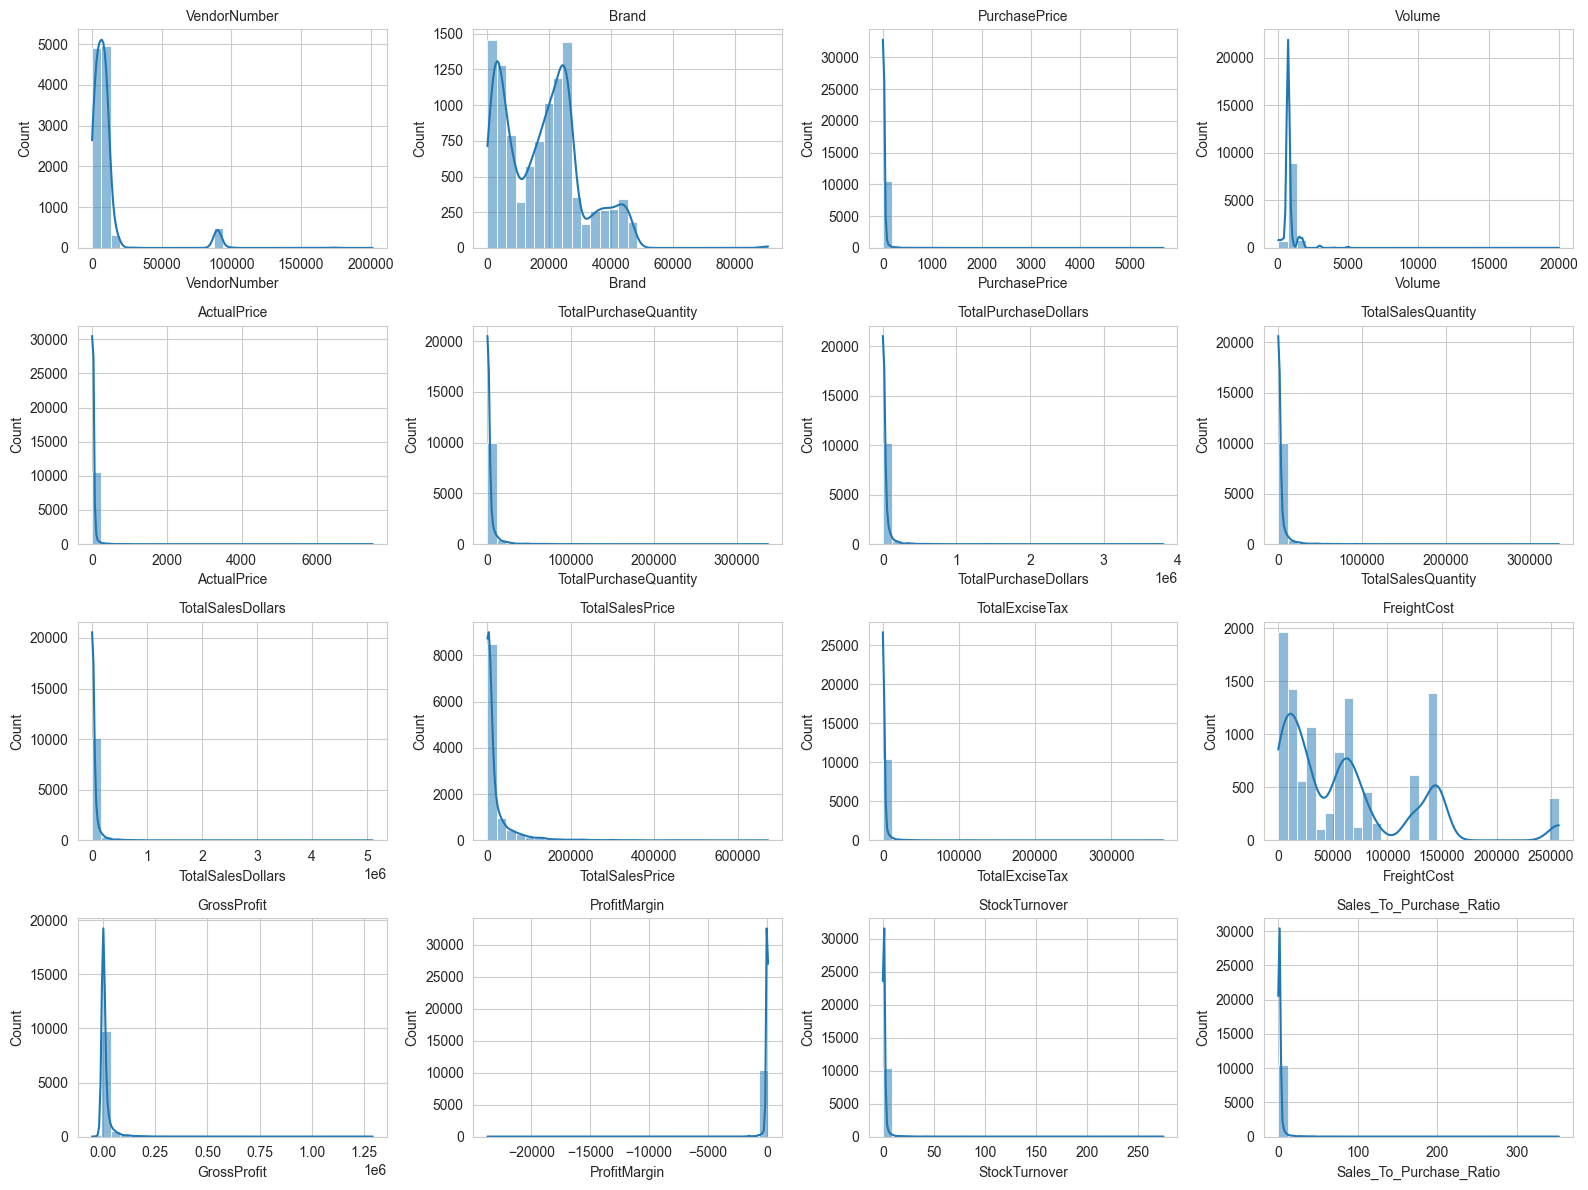

In [4]:
num_cols = df.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i < len(axes):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        
plt.tight_layout()
plt.show()

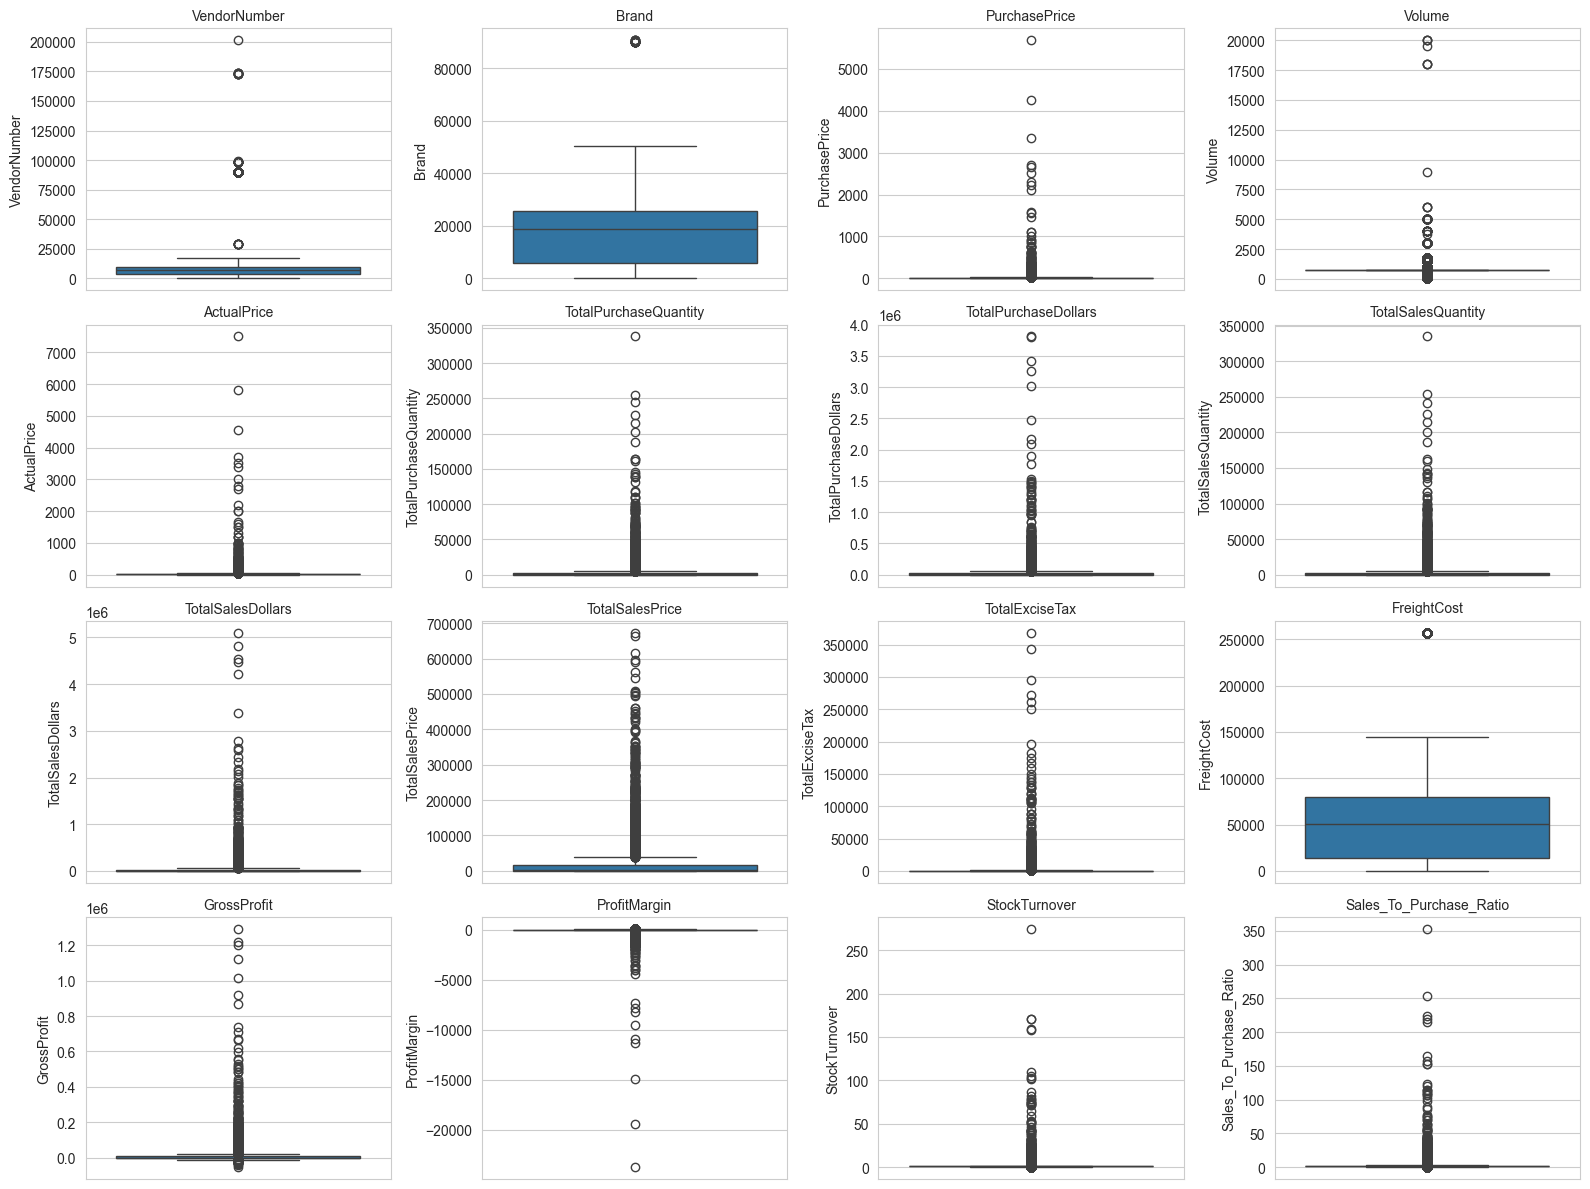

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i < len(axes):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        
plt.tight_layout()
plt.show()

### Insights

**Data Quality Issues:**
- Negative gross profit values indicate losses
- Zero sales quantities suggest unsold inventory
- High variance in freight costs

**Outliers:**
- Premium products with prices >$5,000
- Stock turnover ranges from 0 to 274.5

## Data Cleaning

In [6]:
df = pd.read_sql_query("""
    SELECT * FROM vendor_sales_summary
    WHERE GrossProfit > 0 
        AND ProfitMargin > 0
        AND TotalSalesQuantity > 0
""", conn)

print(f'Filtered dataset: {len(df):,} rows')
df.info()

Filtered dataset: 8,564 rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8564 entries, 0 to 8563
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   VendorNumber             8564 non-null   int64  
 1   VendorName               8564 non-null   object 
 2   Brand                    8564 non-null   int64  
 3   Description              8564 non-null   object 
 4   PurchasePrice            8564 non-null   float64
 5   Volume                   8564 non-null   float64
 6   ActualPrice              8564 non-null   float64
 7   TotalPurchaseQuantity    8564 non-null   int64  
 8   TotalPurchaseDollars     8564 non-null   float64
 9   TotalSalesQuantity       8564 non-null   float64
 10  TotalSalesDollars        8564 non-null   float64
 11  TotalSalesPrice          8564 non-null   float64
 12  TotalExciseTax           8564 non-null   float64
 13  FreightCost              8564 non-null   float64


## Correlation Analysis

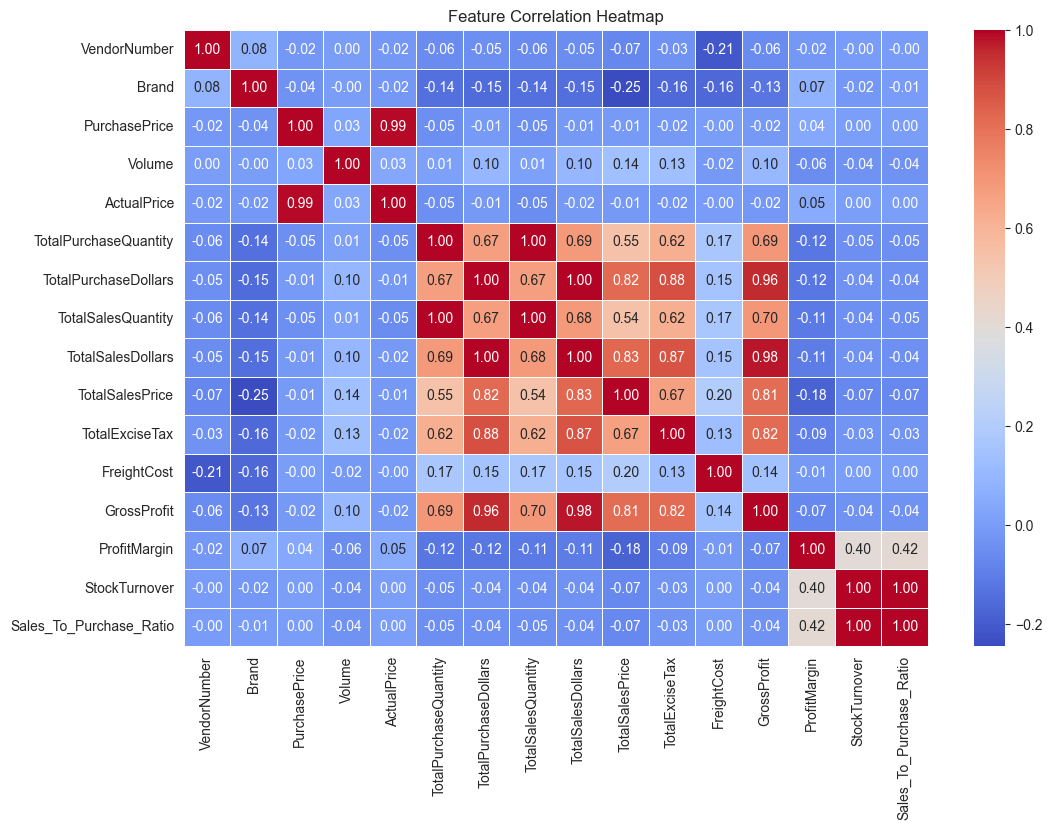

In [7]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Correlation Insights

- **Purchase Price** shows weak correlation with sales (-0.012) and profit (-0.016)
- **Purchase Quantity** vs **Sales Quantity**: Strong positive correlation (0.999)
- **Profit Margin** vs **Sales Price**: Moderate negative correlation (-0.179)
- **Stock Turnover** has weak correlation with profitability metrics

## Business Questions

### 1. Top Vendors and Brands by Sales Performance

In [8]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    return str(value)

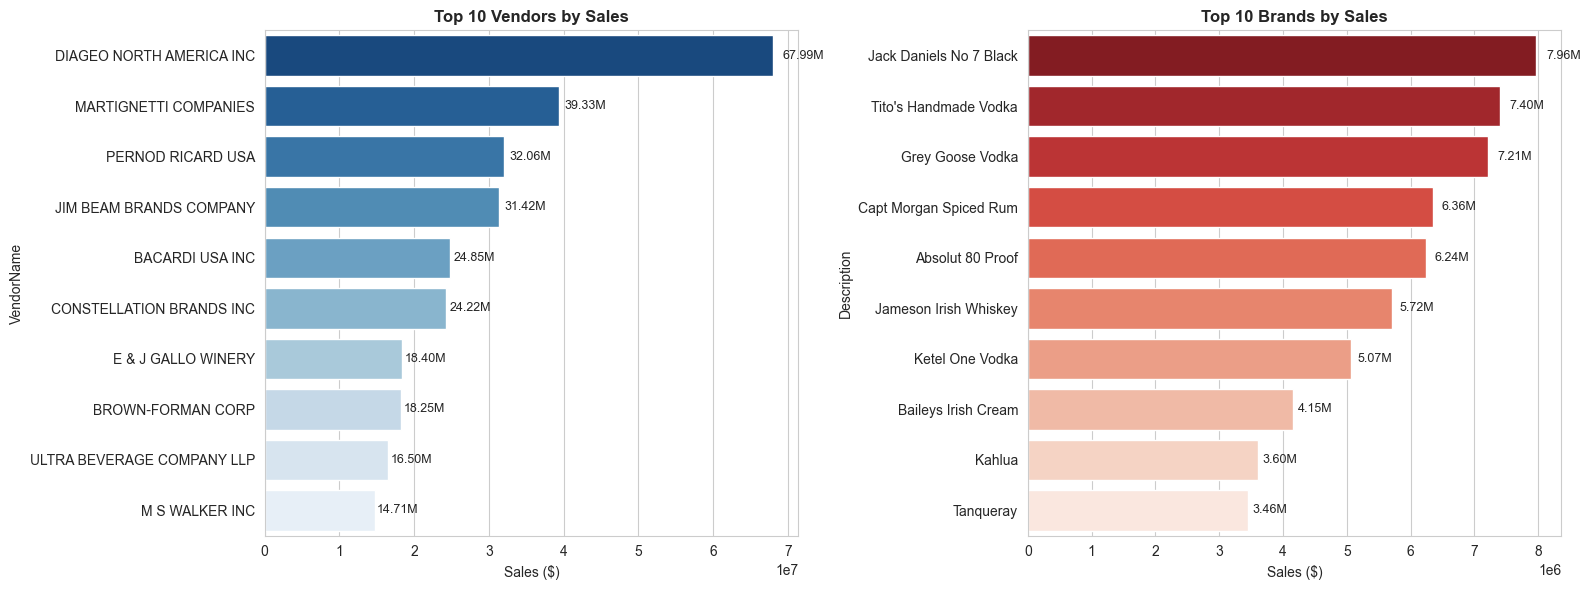

In [9]:
top_vendors = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r", ax=axes[0])
axes[0].set_title("Top 10 Vendors by Sales", fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sales ($)')
for bar in ax1.patches:
    ax1.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()), ha='left', va='center', fontsize=9)

ax2 = sns.barplot(y=top_brands.index, x=top_brands.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("Top 10 Brands by Sales", fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sales ($)')
for bar in ax2.patches:
    ax2.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()), ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 2. Vendor Purchase Contribution

In [10]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum'
}).reset_index()

vendor_performance['PurchaseContribution%'] = (
    vendor_performance['TotalPurchaseDollars'] / 
    vendor_performance['TotalPurchaseDollars'].sum() * 100
)

vendor_performance = vendor_performance.sort_values('PurchaseContribution%', ascending=False)
top_vendors = vendor_performance.head(10).copy()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,16.300345
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,8.297724
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,7.760554
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,7.644441
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,5.671930
20,CONSTELLATION BRANDS INC,15273708.08,8945037.57,24218745.65,4.969671
11,BROWN-FORMAN CORP,13238939.18,5008291.47,18247230.65,4.307609
30,E & J GALLO WINERY,12068539.22,6331360.24,18399899.46,3.926791
106,ULTRA BEVERAGE COMPANY LLP,11167081.61,5335462.70,16502544.31,3.633480
53,M S WALKER INC,9764312.60,4942145.91,14706458.51,3.177055


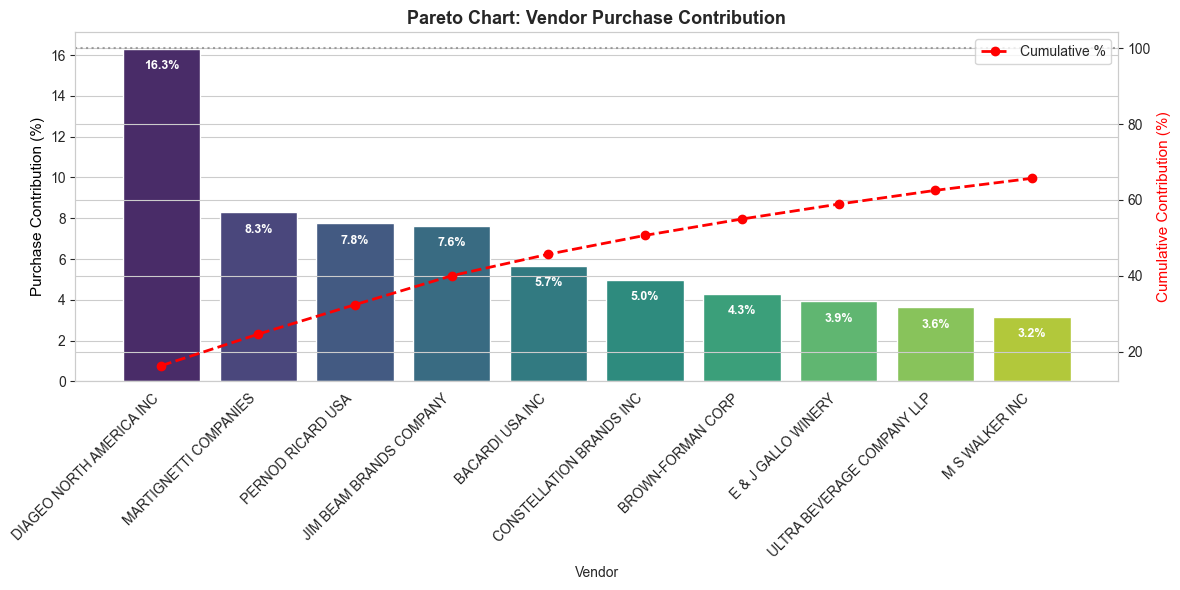


Top 10 vendors contribute 65.69% of total purchases


In [11]:
top_vendors['Cumulative%'] = top_vendors['PurchaseContribution%'].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], 
            palette="viridis", ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i, value - 1, f"{value:.1f}%", ha='center', fontsize=9, color='white', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative%'], 
         color="red", marker='o', linestyle='--', linewidth=2, label='Cumulative %')
ax2.axhline(y=100, color='gray', linestyle=':', alpha=0.7)

ax1.set_xticklabels(top_vendors['VendorName'], rotation=45, ha='right')
ax1.set_ylabel('Purchase Contribution (%)', color="black", fontsize=11)
ax2.set_ylabel('Cumulative Contribution (%)', color="red", fontsize=11)
ax1.set_xlabel('Vendor')
ax1.set_title('Pareto Chart: Vendor Purchase Contribution', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nTop 10 vendors contribute {top_vendors['PurchaseContribution%'].sum():.2f}% of total purchases")

### 3. Bulk Pricing Analysis

In [12]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=['Small', 'Medium', 'Large'])

order_size_stats = df.groupby('OrderSize')['UnitPurchasePrice'].mean()
order_size_stats

OrderSize
Small     39.068186
Medium    15.486414
Large     10.777625
Name: UnitPurchasePrice, dtype: float64

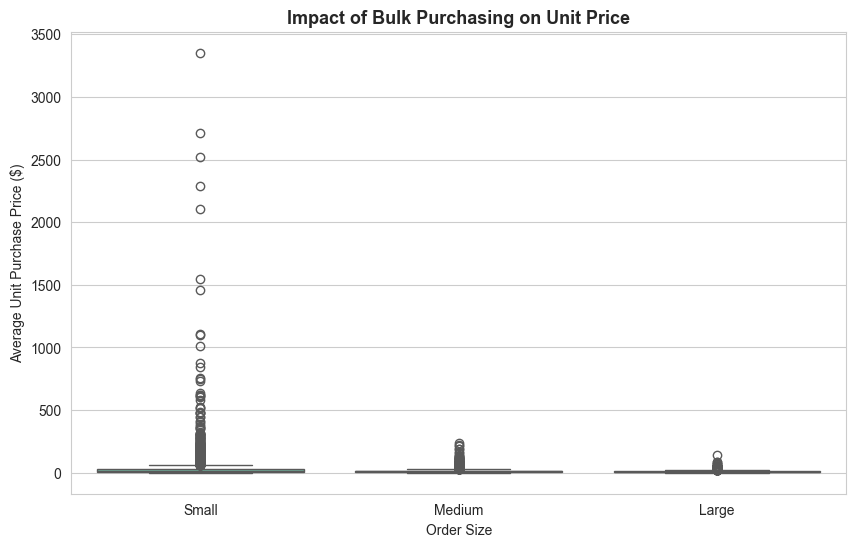

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='OrderSize', y='UnitPurchasePrice', palette='Set2')
plt.title("Impact of Bulk Purchasing on Unit Price", fontsize=13, fontweight='bold')
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price ($)")
plt.show()

**Insight**: Large orders receive ~72% lower unit prices compared to small orders, enabling higher margins with efficient inventory management.

### 4. Low Inventory Turnover Vendors

In [14]:
low_turnover = (df[df['StockTurnover'] < 1]
                .groupby('VendorName')['StockTurnover']
                .mean()
                .sort_values()
                .head(10))
low_turnover

VendorName
ALISA CARR BEVERAGES           0.615385
HIGHLAND WINE MERCHANTS LLC    0.708333
PARK STREET IMPORTS LLC        0.751306
Circa Wines                    0.755676
Dunn Wine Brokers              0.766022
CENTEUR IMPORTS LLC            0.773953
SMOKY QUARTZ DISTILLERY LLC    0.783835
TAMWORTH DISTILLING            0.797078
THE IMPORTED GRAPE LLC         0.807569
WALPOLE MTN VIEW WINERY        0.820548
Name: StockTurnover, dtype: float64

### 5. Unsold Inventory Capital

In [15]:
df['UnsoldInventoryValue'] = (
    (df['TotalPurchaseQuantity'] - df['TotalSalesQuantity']) * df['PurchasePrice']
)

total_unsold = df['UnsoldInventoryValue'].sum()
print(f"Total Unsold Capital: {format_dollars(total_unsold)}")

unsold_by_vendor = (df.groupby('VendorName')['UnsoldInventoryValue']
                    .sum()
                    .sort_values(ascending=False)
                    .head(10))
unsold_by_vendor.apply(format_dollars)

Total Unsold Capital: 2.71M


VendorName
DIAGEO NORTH AMERICA INC    722.21K
JIM BEAM BRANDS COMPANY     554.67K
PERNOD RICARD USA           470.63K
WILLIAM GRANT & SONS INC    401.96K
E & J GALLO WINERY          228.28K
SAZERAC CO INC              198.44K
BROWN-FORMAN CORP           177.73K
CONSTELLATION BRANDS INC    133.62K
MOET HENNESSY USA INC       126.48K
REMY COINTREAU USA INC      118.60K
Name: UnsoldInventoryValue, dtype: object

### 6. Confidence Intervals: Top vs Low Performing Vendors

In [16]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors_pm = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors_pm = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin = t_critical * std_err
    return mean_val, mean_val - margin, mean_val + margin

top_mean, top_lower, top_upper = confidence_interval(top_vendors_pm)
low_mean, low_lower, low_upper = confidence_interval(low_vendors_pm)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low Vendors 95% CI: (40.50, 42.64), Mean: 41.57


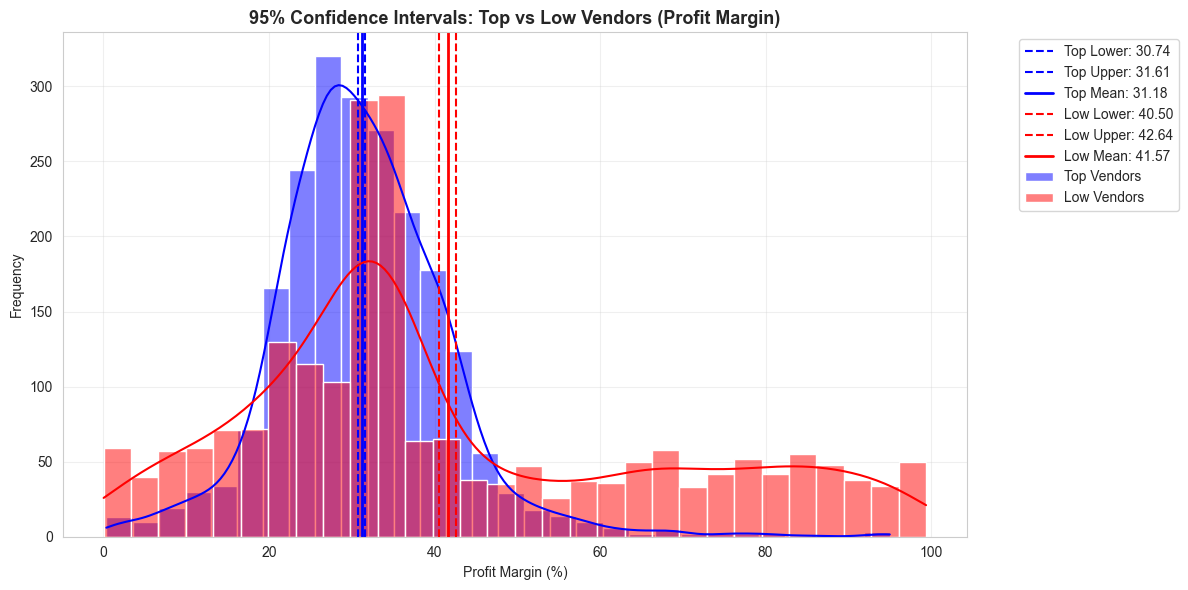

In [17]:
plt.figure(figsize=(12, 6))

sns.histplot(top_vendors_pm, kde=True, color='blue', bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color='blue', linestyle='--', label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color='blue', linestyle='--', label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color='blue', linewidth=2, label=f"Top Mean: {top_mean:.2f}")

sns.histplot(low_vendors_pm, kde=True, color='red', bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color='red', linestyle='--', label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color='red', linestyle='--', label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color='red', linewidth=2, label=f"Low Mean: {low_mean:.2f}")

plt.title("95% Confidence Intervals: Top vs Low Vendors (Profit Margin)", fontsize=13, fontweight='bold')
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Insight**: Low-performing vendors maintain higher profit margins (40.50%–42.64%) vs top performers (30.74%–31.61%), suggesting premium pricing with limited volume.

### 7. Hypothesis Testing: Profit Margin Differences

**H₀**: No significant difference in mean profit margins between top and low-performing vendors
**H₁**: Significant difference exists

In [18]:
t_stat, p_value = ttest_ind(top_vendors_pm, low_vendors_pm, equal_var=False)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")
print()

if p_value < 0.05:
    print("✅ Reject H₀: Significant difference in profit margins between segments")
else:
    print("❌ Fail to Reject H₀: No significant difference")

T-Statistic: -17.6695
P-Value: 0.0000

✅ Reject H₀: Significant difference in profit margins between segments


## Strategic Recommendations

### High-Margin, Low-Sales Brands
- Identify products with profit margins >85th percentile and sales <15th percentile
- Candidates for promotional campaigns or pricing adjustments

In [19]:
brand_performance = df.groupby('Description').agg({
    "TotalSalesDollars": 'sum',
    "ProfitMargin": "mean"
}).reset_index()

low_sales_threshold = brand_performance["TotalSalesDollars"].quantile(0.15)
high_margin_threshold = brand_performance["ProfitMargin"].quantile(0.85)

target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print(f"Identified {len(target_brands)} brands for optimization\n")
target_brands.sort_values('TotalSalesDollars').head(10)

Identified 198 brands for optimization



,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
4828,Merry Irish Cream Liqueur,35.97,73.533500
7184,Tracia Syrah,44.94,88.495772
600,Basilica Amaretto,47.45,85.079031
2934,Flag Hill Heritage Rd NH,49.96,65.532426
5124,New Amsterdam Red Berry Vdka,63.96,81.207004


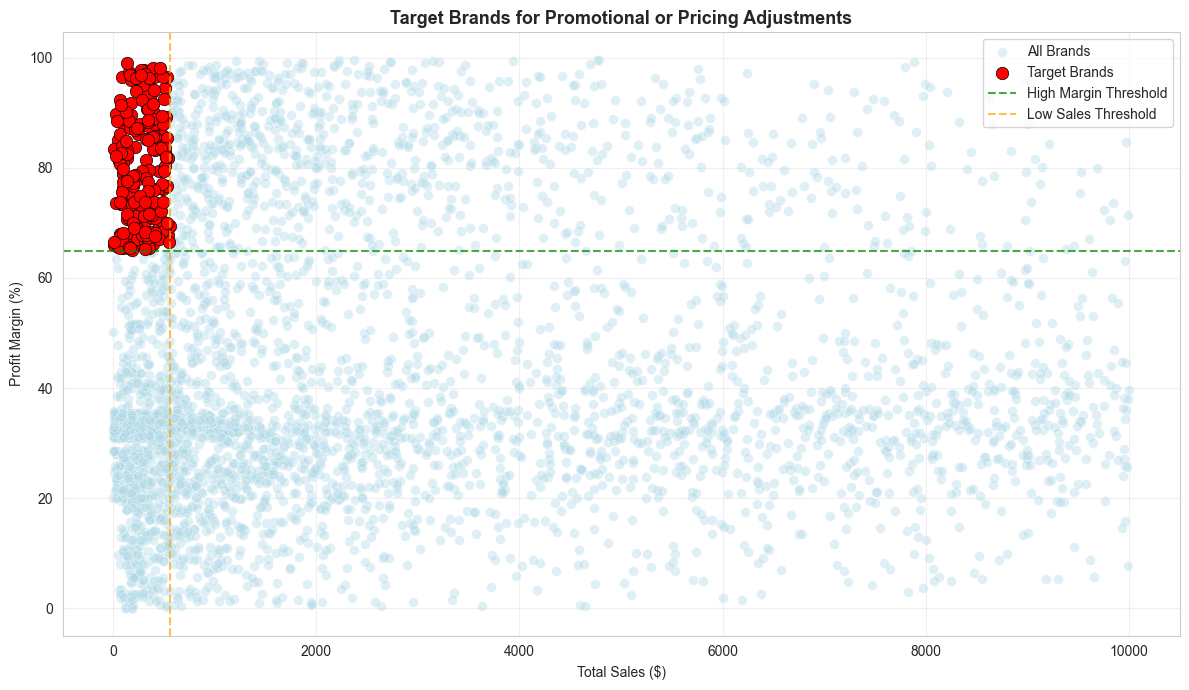

In [20]:
brand_subset = brand_performance[brand_performance['TotalSalesDollars'] < 10000]

plt.figure(figsize=(12, 7))
sns.scatterplot(data=brand_subset, x='TotalSalesDollars', y='ProfitMargin', 
                color='lightblue', label='All Brands', alpha=0.4, s=50)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', 
                color='red', label='Target Brands', s=80, edgecolor='black', linewidth=0.5)

plt.axhline(high_margin_threshold, linestyle='--', color='green', alpha=0.7, label='High Margin Threshold')
plt.axvline(low_sales_threshold, linestyle='--', color='orange', alpha=0.7, label='Low Sales Threshold')

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Target Brands for Promotional or Pricing Adjustments", fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Vendor Concentration**: Top 10 vendors account for majority of purchases
2. **Bulk Discounts**: Large orders reduce unit costs by ~72%
3. **Margin Paradox**: Low-volume vendors maintain higher margins
4. **Capital Efficiency**: Significant unsold inventory locks working capital
5. **Optimization Targets**: Identified high-margin, low-sales brands for intervention

In [21]:
conn.close()